In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNet, Ridge, Lasso
from helper import *
import shap

In [97]:
def one_on_one_plot(var_1: str, var_2: str, df: pd.DataFrame, rate: float = 1.5):
    data_pairplot = pd.concat([df[var_2], df[var_1]], axis=1)
    plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x=var_1, y=var_2, data=data_pairplot)
    y_min = data_pairplot[var_2].min()
    if y_min == 0: y_min = -1
    fig.axis(ymin= y_min / rate, ymax=rate * data_pairplot[var_2].max())

def encode_ordinal(df: pd.DataFrame, col_name: str, feature_dict=None ):
    if feature_dict is None:
        feature_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, "NA": 0}
    return df[col_name].replace(feature_dict).astype("int64")

def one_hot_encode(df: pd.DataFrame, col_name: str, prefix=None):
    """
    One-hot encode nominal categorical variable.
    """
    return df.join(pd.get_dummies(df[col_name], drop_first=True, prefix=col_name)) if not prefix \
        else  df.join(pd.get_dummies(df[col_name], drop_first=True, prefix=prefix))

In [98]:
# """
# Read the data
# """
# data = pd.read_csv("data/train.csv").drop(["Id"], axis=1)
# data_test = pd.read_csv("data/test.csv")
# data_sub = pd.read_csv("data/submission.csv")
#
# data_extend = pd.concat([data_test, data_sub], axis=1).drop(["Id"], axis=1)
# data  = pd.concat([data, data_extend])
#
# """
# drop unused features
# """
# data = data.drop(["MiscFeature", 'Utilities', 'MiscVal', 'GarageArea'],axis=1)
# """
# summarize all bathrooms data into one.
# """
# data['Bathrooms'] = data["BsmtFullBath"] + 0.5 * data["BsmtHalfBath"] + data["FullBath"] + 0.5 * data["HalfBath"]
#
# data = data.drop(["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"], axis=1)
# data.insert(0, 'Bathrooms', data.pop('Bathrooms'))
# data.to_csv("data/data_all.csv")

In [99]:
data = pd.read_csv("data/data_all.csv")
data = data.drop(["Unnamed: 0"], axis=1)


In [100]:
data = data[data['Exterior1st'].notna()]
data = data[data['Exterior2nd'].notna()]
data = data[data['GarageCars'].notna()]

data = data[data['Bathrooms'].notna()]
for col in data.columns:
    print(col,data[col].isna().sum())

Bathrooms 0
MSSubClass 0
MSZoning 4
LotFrontage 486
LotArea 0
Street 0
Alley 2717
LotShape 0
LandContour 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 24
MasVnrArea 23
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 79
BsmtCond 80
BsmtExposure 80
BsmtFinType1 77
BsmtFinSF1 0
BsmtFinType2 78
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 1
TotRmsAbvGrd 0
Functional 2
Fireplaces 0
FireplaceQu 1418
GarageType 156
GarageYrBlt 157
GarageFinish 157
GarageCars 0
GarageQual 157
GarageCond 157
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 2905
Fence 2346
MoSold 0
YrSold 0
SaleType 1
SaleCondition 0
SalePrice 0


In [101]:
data['Bathrooms'].value_counts()
# data

2.0    900
2.5    558
1.0    442
3.0    378
1.5    293
3.5    288
4.0     31
4.5     17
5.0      3
7.0      3
6.0      2
Name: Bathrooms, dtype: int64

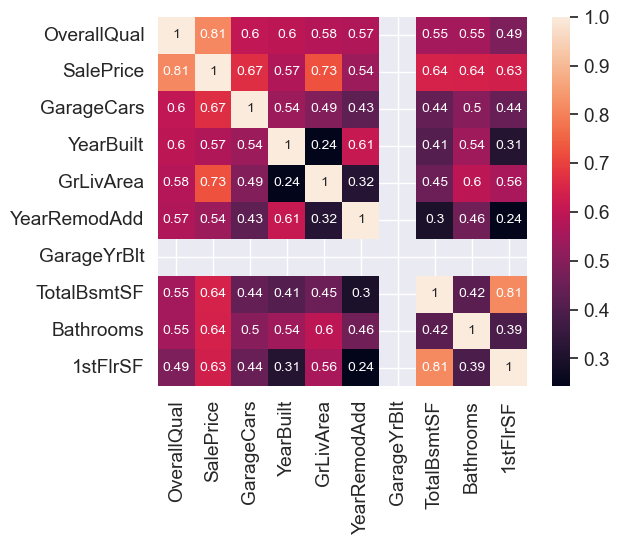

In [102]:
corrmat = data.corr(numeric_only=True)
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'OverallQual')['OverallQual'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


In [103]:
'''
Explore LotFrontage, fill NaN column with Avg from each neighborhood.
'''
print(data["LotFrontage"].isna().sum())
neighborhoods = set(data['Neighborhood'])
mean_LF_per_neighborhood = {}
for neighborhood in neighborhoods:
    mean_LF_per_neighborhood[neighborhood] = data.loc[data['Neighborhood'] == neighborhood, 'LotFrontage'].mean()
data['LotFrontage'] = data['LotFrontage'].fillna(data['Neighborhood'].map(mean_LF_per_neighborhood))


486


In [104]:
data['GarageCond'].value_counts()

TA    2652
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64

### Explore Garage:
- FillNa of GarageYrBlt with value from YearBuilt.
- FillNa of other with 'NA' (str), except GarageType
- GarageType: One-hot encode.
- Other garage features (ordinal): ordinal encode.

In [92]:
data_garage = [ "GarageCond", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars" , "GarageQual"]

data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data["YearBuilt"])

for col in data_garage:
    print(col, data[col].isna().sum())

data['GarageCond'] = data['GarageCond'].fillna('TA')
data['GarageCond'] = encode_ordinal(data, 'GarageCond')

GarageFinish_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
GarageQual_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}

data['GarageFinish'] = data['GarageFinish'].fillna('NA')
data['GarageFinish'] = encode_ordinal(data, 'GarageFinish', GarageFinish_dict)

data['GarageQual'] = data['GarageQual'].fillna('NA')
data['GarageQual'] = encode_ordinal(data, 'GarageQual')

data = one_hot_encode(data, 'GarageType')
data = data.drop(['GarageType'], axis=1)


GarageCond 157
GarageType 156
GarageYrBlt 0
GarageFinish 157
GarageCars 0
GarageQual 157


### Basement features:
- Temporary drop some basement for now, only keep Qual and Cond

In [46]:
data['BsmtQual'] = data['BsmtQual'].fillna('TA')
data['BsmtCond'] = data['BsmtCond'].fillna('TA')

data['BsmtQual'] = encode_ordinal(data, 'BsmtQual')
data['BsmtCond'] = encode_ordinal(data, 'BsmtCond')

data['UnfBsmtRat'] = data['BsmtUnfSF'] / data['TotalBsmtSF']

data['UnfBsmtRat'] = data['UnfBsmtRat'].fillna(0)
data = data.drop(['BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'], axis=1)

### Masonry veneer features:
- Type: FillNa with NA.
- Area: FillNa with 0

In [ ]:
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

data = one_hot_encode(data, 'MasVnrType')
data = data.drop(['MasVnrType', 'MasVnrType_None'], axis=1)

### Zoning data:
- MSZoning: Onehot
- MsSubClass: Change to object + onehot
- Update: drop?

In [ ]:
# data = one_hot_encode(data, 'MSZoning')
data = data.drop(['MSZoning'], axis=1)
# data['MSSubClass'] = data['MSSubClass'].astype(object)
# data['MSSubClass'].value_counts()
#
# data = one_hot_encode(data, 'MSSubClass')
data = data.drop(['MSSubClass'], axis=1)

### Functional, Kitchen:
- Ordinal encoding.

In [ ]:
Functional_dict = {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ":7}

data = data[data['Functional'].notna()]
data = data[data['KitchenQual'].notna()]
data['Functional'] = encode_ordinal(data, 'Functional', feature_dict=Functional_dict)
data['KitchenQual'] = encode_ordinal(data, 'KitchenQual')


### Exterior feature:

- Material: One-hot encode both Exterior 1st and Exterior 2nd together.
- Qual and cond: Ordinal Encoding.

In [ ]:



data.loc[data['Exterior1st'] == data['Exterior2nd'],  'Exterior2nd'] = None
data['Exterior2nd'] = data['Exterior2nd'].replace({'Brk Cmn': 'BrkComm', 'Wd Shng': 'WdShing' }).astype("str")

data = data.join(
pd.get_dummies(data.filter(like='Exterior').stack(), prefix='Exterior')
  .groupby(level=0).max())


data = data.drop(['Exterior1st', 'Exterior2nd', 'Exterior_None', 'Exterior_Other'], axis=1)
data['ExterQual'] = encode_ordinal(data, 'ExterQual')
data['ExterCond'] = encode_ordinal(data, 'ExterCond')




### Electrical:
- Fill Na with the most common (SBrKr)
- Change mix to FuseA (average)
- Ordinal encoding.

In [ ]:
data['Electrical'] = data['Electrical'].fillna('SBrkr')
Electrical_dict = {'SBrkr' : 3, 'FuseA': 2, 'FuseF': 1, 'FuseP' : 0, 'Mix': 2}
print(data['Electrical'].value_counts())
data['Electrical'] = encode_ordinal(data, 'Electrical', feature_dict=Electrical_dict)

SBrkr    2667
FuseA     186
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


### SaleType and SaleCondition:
- Drop for now.

In [ ]:
data = data.drop(['SaleType', 'SaleCondition'], axis=1)

### Heating:
- Type: drop
- Quality: Ordinal
- CentralAir: Encode 0-1


In [ ]:
data['CentralAir'] = data["CentralAir"].replace({'Y': 1, 'N' : 0}).astype("int64")

print(data[["CentralAir"]].value_counts())
print(data[["Heating"]].value_counts())
print(data[["HeatingQC"]].value_counts())

print(data[["CentralAir"]].isna().sum())
print(data[["Heating"]].isna().sum())
print(data[["HeatingQC"]].isna().sum())

data['HeatingQC'] = encode_ordinal(data, 'HeatingQC')
data = data.drop(['Heating'], axis=1)

CentralAir
1             2718
0              194
dtype: int64
Heating
GasA       2868
GasW         27
Grav          9
Wall          5
OthW          2
Floor         1
dtype: int64
HeatingQC
Ex           1491
TA            855
Gd            473
Fa             91
Po              2
dtype: int64
CentralAir    0
dtype: int64
Heating    0
dtype: int64
HeatingQC    0
dtype: int64


### Roof:
- Style and mat: One-hot Encoding

In [ ]:
print(data['RoofStyle'].value_counts())
print(data[["RoofStyle"]].isna().sum())
print(data['RoofMatl'].value_counts())
print(data[["RoofMatl"]].isna().sum())

data = one_hot_encode(data, 'RoofStyle')
data = data.drop(['RoofStyle'], axis=1)

data = one_hot_encode(data, 'RoofMatl')
data = data.drop(['RoofMatl'], axis=1)

Gable      2304
Hip         551
Gambrel      22
Flat         19
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64
RoofStyle    0
dtype: int64
CompShg    2870
Tar&Grv      22
WdShake       9
WdShngl       7
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64
RoofMatl    0
dtype: int64


### Land:
- Slope: Ordinal encoding
- Contour: one-hot.

In [ ]:
print(data['LandContour'].value_counts())
print(data[["LandContour"]].isna().sum())

data = one_hot_encode(data, 'LandContour')
data = data.drop(['LandContour'], axis=1)

print(data['LandSlope'].value_counts())
print(data[["LandSlope"]].isna().sum())


LandSlope_dict = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
data['LandSlope'] = encode_ordinal(data, 'LandSlope', feature_dict=LandSlope_dict)


Lvl    2616
HLS     120
Bnk     117
Low      59
Name: LandContour, dtype: int64
LandContour    0
dtype: int64
Gtl    2772
Mod     124
Sev      16
Name: LandSlope, dtype: int64
LandSlope    0
dtype: int64


### Foundation:
- One-hot encoding

In [55]:
print(data['Foundation'].value_counts())
print(data[["Foundation"]].isna().sum())
data = one_hot_encode(data, 'Foundation')
data = data.drop(['Foundation'], axis=1)

PConc     1306
CBlock    1234
BrkTil     309
Slab        47
Stone       11
Wood         5
Name: Foundation, dtype: int64
Foundation    0
dtype: int64


### Dwelling:
- Drop for now (BldgType and houseStyle)

In [56]:
data = data.drop(['BldgType', 'HouseStyle'], axis=1)

### Paved Street and Paved Driveway:
- Onehot Encoded.

In [58]:
data["Street"] = data["Street"].replace({'Pave': 1, 'Grvl' : 0}).astype("int64")
data["PavedDrive"] = data["PavedDrive"].replace({'Y': 2, 'P': 1, 'N' : 0}).astype("int64")


### Neigborhood-related:
- Neighborhood: remove? Because how is neighborhood affect house quality? Will see later.
- Condition 1 and 2: dropped

In [60]:
# data = one_hot_encode(data, 'Neighborhood')
data = data.drop(['Condition1', 'Condition2', 'Neighborhood'], axis=1)

### Fireplaces

In [62]:
data['FireplaceQu'] = data['FireplaceQu'].fillna("NA")
data_cat_ordinal = data[["FireplaceQu"]].columns

FireplaceQu_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, "NA": 3}
data['FireplaceQu'] = encode_ordinal(data, 'FireplaceQu', FireplaceQu_dict)


### Alley:
- Too many missing -> drop

In [64]:
data = data.drop(['Alley'], axis=1)

### Porch-area related features:
- Drop for now

In [66]:
data = data.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

### Total area of the house

In [67]:
# data['TotalSqFt'] = data['GrLivArea'] + data['TotalBsmtSF']
data['UnfSqFtRatio'] = data['LowQualFinSF'] / data['GrLivArea']
data = data.drop(['GrLivArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'LotArea', 'LotFrontage'], axis=1)

### Year and age:
- Age: Year sold - renovated.
- IsNew: If sold right after built
- IsRennovated: If the house is rennovated or not.

In [68]:
data['Age'] =  data['YrSold'] - data['YearRemodAdd']
data['IsNew'] =  data['YrSold'] == data['YearBuilt']
data['Renovated'] = data['YearRemodAdd'] != data['YearBuilt']
data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']

data = data.drop(['MoSold', 'YrSold', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd'], axis=1)

data[['Renovated', 'IsNew']] = data[['Renovated', 'IsNew']].astype(int)

### Pool
- Drop Area, keep quality.

In [69]:

data["PoolQC"] = data["PoolQC"].fillna("NA")
PoolQC_dict = {'Ex': 1, 'Gd': 1, 'TA': 1, 'Fa': 1, 'Po': 1, "NA": 0}
data['HasPool'] = encode_ordinal(data, 'PoolQC', PoolQC_dict)
data = data.drop(['PoolArea', 'PoolQC'], axis=1)

In [70]:
corrmat = data.corr(numeric_only=True)
k = 15 #number of variables for heatmap

print(corrmat.nlargest(k, 'OverallQual')['OverallQual'])
print(corrmat.nsmallest(5, 'OverallQual')['OverallQual'])


OverallQual         1.000000
SalePrice           0.811936
ExterQual           0.732315
KitchenQual         0.676955
BsmtQual            0.643052
GarageCars          0.602171
Foundation_PConc    0.568240
GarageFinish        0.551346
Bathrooms           0.546869
HeatingQC           0.471886
MasVnrArea          0.426262
Fireplaces          0.391582
TotRmsAbvGrd        0.389542
FireplaceQu         0.376320
Exterior_VinylSd    0.366979
Name: OverallQual, dtype: float64
GarageAge           -0.576599
Age                 -0.572617
Foundation_CBlock   -0.411396
GarageType_Detchd   -0.341765
RoofStyle_Gable     -0.188611
Name: OverallQual, dtype: float64


### Fence:
- Drop for now.

In [71]:
data = data.drop(['Fence', 'LotShape', 'LotConfig', 'TotRmsAbvGrd'], axis=1)

### Taking log of some SalePrice variable.

In [72]:
import statsmodels.api as sm
import pylab as py
from scipy import stats
# stats.probplot(data['SalePrice'], plot=plt)
data['SalePrice'] = np.log(data['SalePrice'])

In [73]:
"""
Train a model for Overall Quality prediction
"""
y = data["OverallQual"]
X = data.drop(["OverallQual", 'SalePrice'], axis=1)
# X = normalization(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=100, stratify=y )

ridge = RidgeCV()
ridge.fit(X_train, y_train)
print(ridge.score(X_test, y_test))
y_pred = ridge.predict(X)

y_score = pd.DataFrame(y_pred, columns=['Prediction'])
y_score['GroundTruth'] = np.array(y)
mean = y_score['GroundTruth'].mean()
y_score['AbsoluteError'] = abs(y_score['GroundTruth'] - y_score['Prediction'])
y_doubt = y_score[y_score['AbsoluteError'] > 1.5]
y_correct = y_score[y_score['AbsoluteError'] < 0.1]
y_doubt

0.7462750583154109


,Prediction,GroundTruth,AbsoluteError
74,4.825003,3,1.825003
148,5.444268,7,1.555732
155,4.363951,6,1.636049
181,5.237838,7,1.762162
183,5.491967,7,1.508033
...,...,...,...
2799,5.346462,7,1.653538
2851,5.672220,4,1.672220
2864,4.252071,2,2.252071
2878,6.666691,5,1.666691


In [74]:

# data = data.iloc[y_score[y_score['AbsoluteError'] < 3].index]
#
# y = data["OverallQual"]
# X = data.drop(["OverallQual", 'SalePrice'], axis=1)
# # X = normalization(X)
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=100, stratify=y )
#
# ridge = RidgeCV()
# ridge.fit(X_train, y_train)
# print(ridge.score(X_test, y_test))
# y_pred = ridge.predict(X)
#
# y_score = pd.DataFrame(y_pred, columns=['Prediction'])
# y_score['GroundTruth'] = np.array(y)
# mean = y_score['GroundTruth'].mean()
# y_score['AbsoluteError'] = abs(y_score['GroundTruth'] - y_score['Prediction'])
# y_doubt = y_score[y_score['AbsoluteError'] > 1.5]
# y_correct = y_score[y_score['AbsoluteError'] < 0.1]
# y_doubt


In [75]:
X_doubt = X.iloc[y_doubt.index]
X_correct = X.iloc[y_correct.index]

In [76]:
# ridge_coef = sorted(ridge.coef_, reverse=True)
#
# for i in range(X.shape[1]):
#     print(X.columns[i], "=", ridge_coef[i].round(5))

In [77]:
#
# shap.partial_dependence_plot(
#     "OverallCond", ridge.predict, X, ice=False,
#     model_expected_value=True, feature_expected_value=True
# )
# plt.figure(figsize=(20, 20))


In [78]:
explainer = shap.Explainer(ridge, X, algorithm="linear", seed=100)
shap_values = explainer(X)


In [79]:
# """
# Corrupt Overall quality.
# """
# OverallQual_sample_fraction = 0
# for i in data['OverallQual'].sample(frac = OverallQual_sample_fraction, random_state=1).index:
#     data.loc[i, 'OverallQual'] = np.random.randint(1, 11, 1)[0]
# shap.summary_plot(shap_values, X, feature_names=X_train.columns, plot_type="bar", max_display=200)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


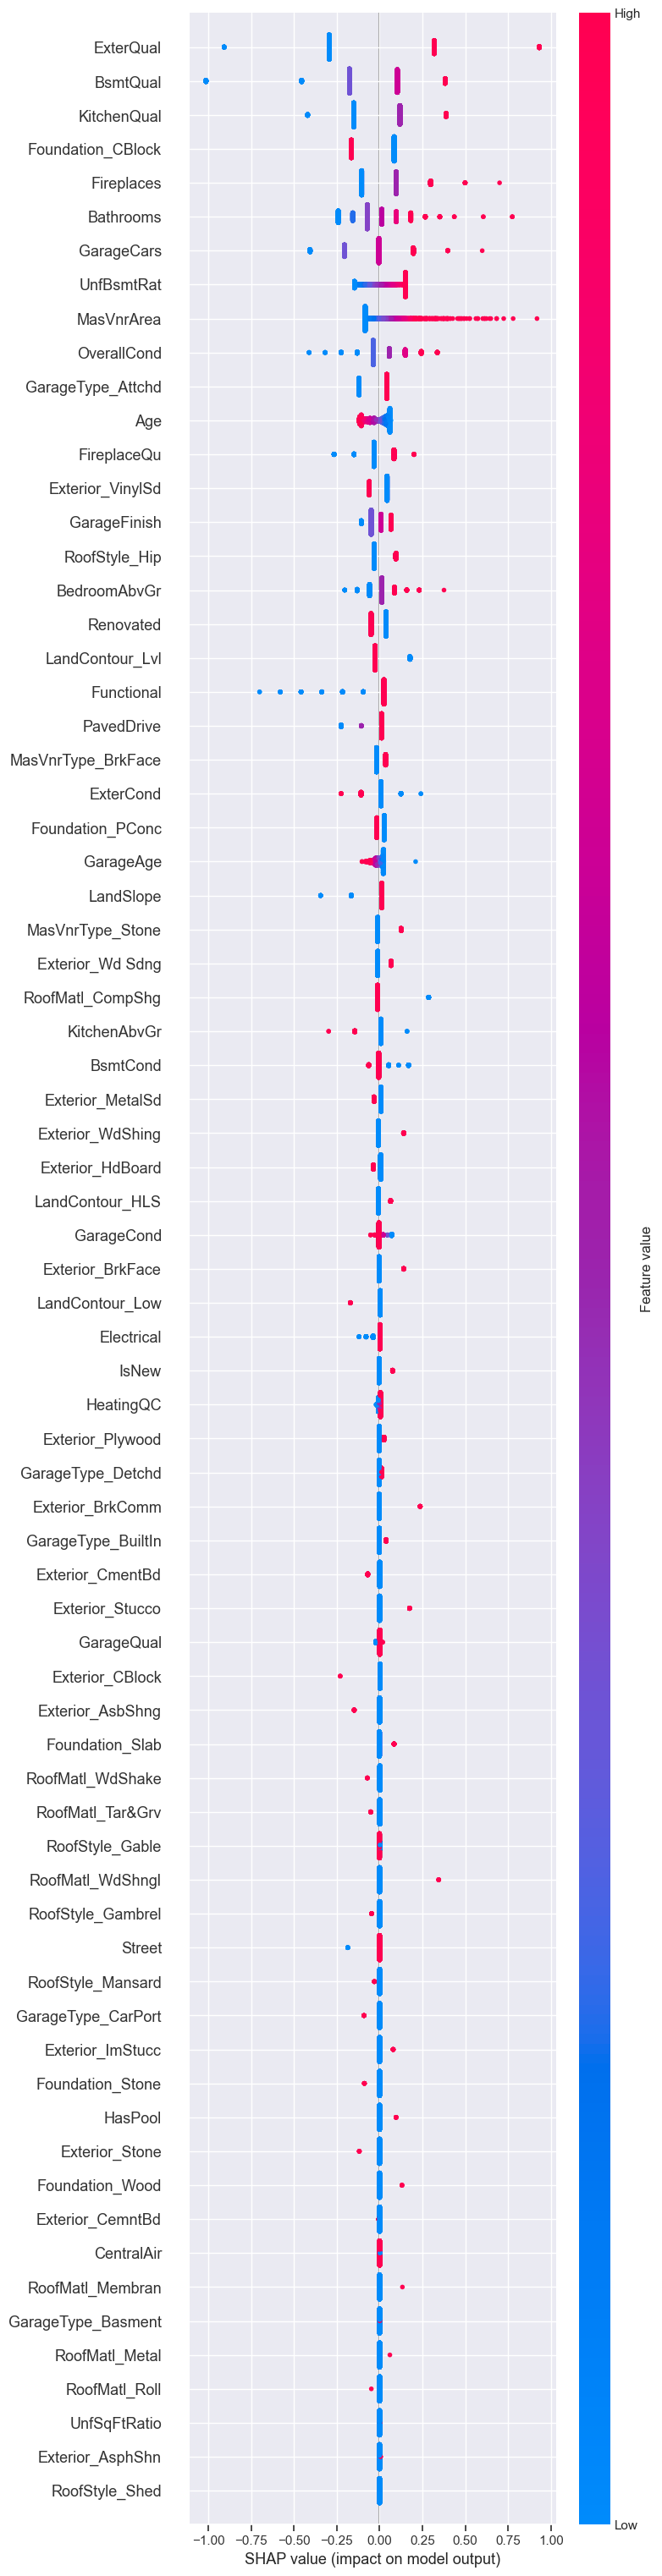

In [80]:
shap.summary_plot(shap_values, X, feature_names=X.columns, max_display=200)

In [42]:
shap.initjs()

In [43]:
# print(y_doubt.iloc[0,:])
ex = shap.KernelExplainer(ridge.predict, X)
shap_values_doubt = ex.shap_values(X_doubt.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values_doubt, X_doubt.iloc[0,:])

X does not have valid feature names, but RidgeCV was fitted with feature names
Using 2912 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
X does not have valid feature names, but RidgeCV was fitted with feature names
X does not have valid feature names, but RidgeCV was fitted with feature names


In [44]:
# pd.DataFrame([shap_values_doubt], columns=X_doubt.columns).T

In [45]:
'''
Experiment:
- Original dataset, get doubtful value
- Corrupt this attrubute (the non-doubtful)
- See if the model discover the pattern.5
'''

'\nExperiment:\n- Original dataset, get doubtful value\n- Corrupt this attrubute (the non-doubtful)\n- See if the model discover the pattern.5\n'

In [46]:
# shap_values_correct = ex.shap_values(X_correct.iloc[0,:])
# shap.force_plot(ex.expected_value, shap_values_correct, X_correct.iloc[0,:])

In [47]:
# data_qual_cond = data[['OverallQual', 'GarageCond', 'GarageQual', 'ExterCond', 'ExterQual', 'BsmtCond', 'GarageFinish', 'GarageCars', 'UnfBsmtRat']]
data.corr()['OverallQual']

Bathrooms      0.222096
Street         0.072886
LandSlope      0.019290
OverallQual    1.000000
OverallCond   -0.096512
                 ...   
Age           -0.572617
IsNew          0.239838
Renovated     -0.088035
GarageAge     -0.576599
HasPool        0.071207
Name: OverallQual, Length: 75, dtype: float64

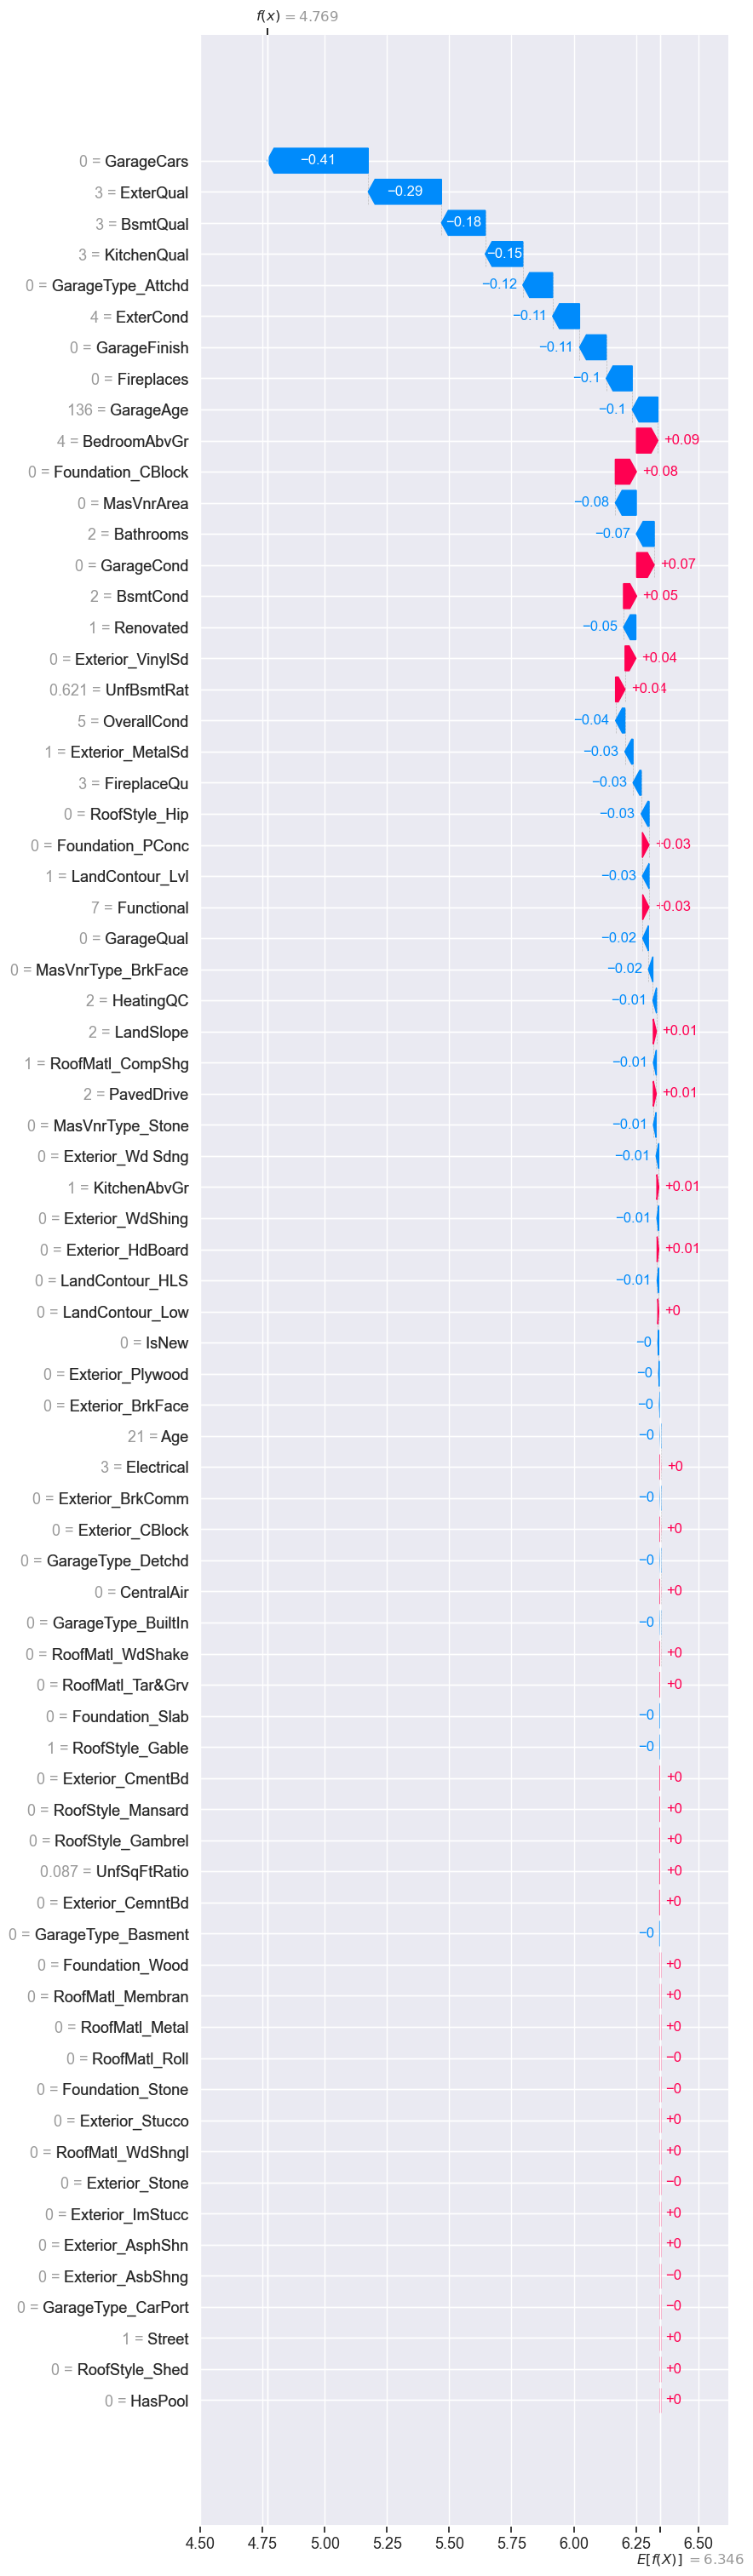

8


In [81]:
shap.plots.waterfall(shap_values[1349], max_display=75)
print(y[1349])

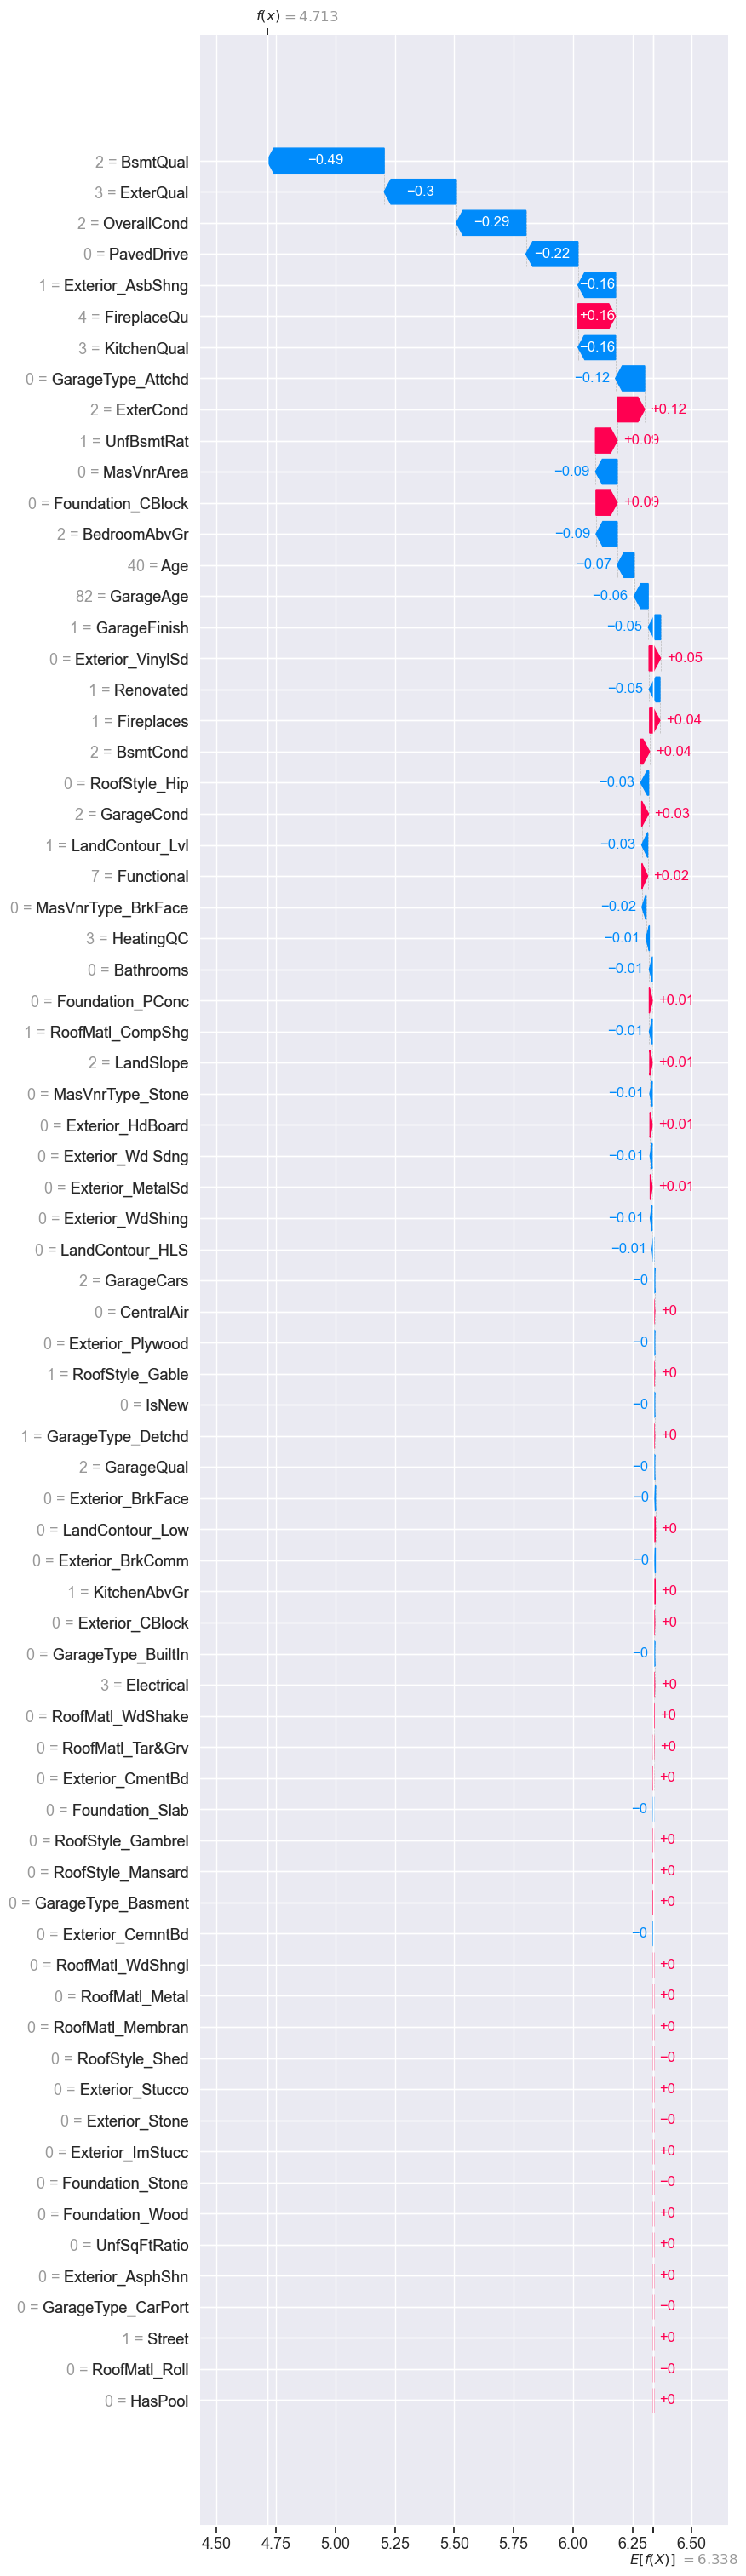

2


In [49]:
shap.plots.waterfall(shap_values[1536], max_display=75)
print(y[1536])

In [50]:
"""
Questions for now: Why is UnfBsmtRat positive impact on Ovr Quality?
Row 1349: super doubtful.
"""

'\nQuestions for now: Why is UnfBsmtRat positive impact on Ovr Quality?\nRow 1349: super doubtful.\n'

In [82]:
data['BsmtCond'].value_counts()

3    2604
4     122
2     102
0      79
1       5
Name: BsmtCond, dtype: int64